  Mounting on the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/SML'

Import Library

In [ ]:
!pip install tensorflow-addons==0.8.3

In [ ]:
%load_ext tensorboard

import datetime

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Import the dataset

In [ ]:
train = pd.read_csv(DATA_DIR + "/train.csv")
train["date_time"] = pd.to_datetime(train["date_time"], format = "%Y-%m-%d %H:%M:%S")
test = pd.read_csv(DATA_DIR + "/test.csv")
test["date_time"] = pd.to_datetime(test["date_time"], format = "%Y-%m-%d %H:%M:%S")

In [ ]:
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['weekday'] = train['date_time'].dt.dayofweek
train["working_hours"] =  train["hour"].isin(np.arange(8, 21, 1)).astype("int")
train["weekend"] = (train["date_time"].dt.dayofweek >= 5).astype("int")

In [ ]:
train = train[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'sensor_2',
                'sensor_3',
                'sensor_4',
                'sensor_5',
                'target_carbon_monoxide',
                'target_benzene',
                'target_nitrogen_oxides'
                 ]]

Extrat date and time

In [ ]:
test['date_time'] = test['date_time'].astype('datetime64[ns]')
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['weekday'] = test['date_time'].dt.dayofweek
test["working_hours"] =  test["hour"].isin(np.arange(8, 21, 1)).astype("int")
test["weekend"] = (test["date_time"].dt.dayofweek >= 5).astype("int")

In [ ]:
test = test[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'sensor_2',
                'sensor_3',
                'sensor_4',
                'sensor_5'
                 ]]

Normalization


In [ ]:
minmax = MinMaxScaler()
train_df = train.iloc[:,1:-3]
test_df = test.iloc[:,1:]
all_df = pd.concat([train_df,test_df], axis = 0)
all_df = pd.DataFrame(minmax.fit_transform(all_df))
X = all_df.iloc[:len(train),:]
test = all_df.iloc[len(train):,:]
y = train.iloc[:,-3:]
X.shape, test.shape, y.shape

((7111, 13), (2247, 13), (7111, 3))

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.31106,0.78261,0.30000,0.33333,0.00000,1.00000,0.45299,0.28007,0.52241,0.37587,0.33029,0.51012,0.45231
1,0.31315,0.82609,0.30000,0.33333,0.00000,1.00000,0.44444,0.26428,0.44877,0.27333,0.39299,0.38759,0.33340
2,0.30063,0.86957,0.30000,0.33333,0.00000,1.00000,0.57753,0.27635,0.48474,0.29460,0.33215,0.44457,0.37806
3,0.26722,0.91304,0.30000,0.33333,0.00000,0.00000,0.65324,0.29419,0.47732,0.29429,0.35107,0.42382,0.43960
4,0.28601,0.95652,0.30000,0.33333,0.00000,0.00000,0.61172,0.29522,0.44394,0.25509,0.38563,0.37320,0.38446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106,0.22965,0.86957,1.00000,0.66667,0.00000,1.00000,0.28205,0.09891,0.25899,0.23376,0.24920,0.16131,0.29114
7107,0.22756,0.91304,1.00000,0.66667,0.00000,0.00000,0.29670,0.09378,0.27411,0.22287,0.28403,0.16294,0.28816
7108,0.23800,0.95652,1.00000,0.66667,0.00000,0.00000,0.31380,0.12036,0.28890,0.21121,0.24428,0.15303,0.39578
7109,0.20459,1.00000,1.00000,0.66667,0.00000,0.00000,0.38828,0.10937,0.22650,0.17247,0.26493,0.16466,0.41565


Training and Testing split

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training and Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12
5837,0.19833,1.00000,0.23333,0.00000,0.00000,0.00000,0.60317,0.23139,0.16798,0.26053,0.25257,0.26309,0.31505
2573,0.54071,1.00000,0.80000,0.66667,0.00000,0.00000,0.26618,0.36265,0.28822,0.34494,0.23130,0.43616,0.36278
5704,0.50313,0.43478,0.06667,0.33333,0.00000,1.00000,0.46642,0.60514,0.46356,0.46270,0.08645,0.51326,0.50370
3555,0.47808,0.91304,0.13333,0.50000,0.00000,0.00000,0.94994,0.87328,0.21907,0.21121,0.21907,0.42604,0.27991
2329,0.63048,0.82609,0.46667,0.16667,0.00000,1.00000,0.27228,0.50100,0.34046,0.48788,0.14569,0.63487,0.39877
...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.31106,0.17391,0.36667,0.00000,0.00000,0.00000,0.24176,0.14763,0.10579,0.04963,0.71814,0.18457,0.02092
6407,0.36117,0.73913,0.03333,0.50000,0.00000,1.00000,0.72161,0.53071,0.65143,0.57003,0.07205,0.59153,0.66104
5625,0.46973,0.13043,1.00000,1.00000,1.00000,0.00000,0.68498,0.67566,0.24033,0.20582,0.27543,0.34346,0.20490
5759,0.54280,0.73913,0.13333,0.66667,0.00000,1.00000,0.56654,0.64600,0.78760,0.71095,0.01790,0.87174,0.83740


In [ ]:
y_carbon = y_train['target_carbon_monoxide']
y_benzene = y_train['target_benzene']
y_nitrogen = y_train['target_nitrogen_oxides']
yval_carbon = y_val['target_carbon_monoxide']
yval_benzene = y_val['target_benzene']
yval_nitrogen = y_val['target_nitrogen_oxides']

y_c = y['target_carbon_monoxide']
y_b = y['target_benzene']
y_n = y['target_nitrogen_oxides']
ytst_carbon = y_test['target_carbon_monoxide']
ytst_benzene = y_test['target_benzene']
ytst_nitrogen = y_test['target_nitrogen_oxides']

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()
mse = tf.keras.losses.MeanSquaredError()
mape = tf.keras.losses.MeanAbsolutePercentageError()
mae = tf.keras.losses.MeanAbsoluteError()

callback = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss', min_delta=1e-6, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=40, verbose=0,
    mode='auto')

Model for Benzene

In [ ]:
#Dependencies
# Neural network
def make_model_benzene():
  model = Sequential()
  model.add(Dense(1024, input_dim=13, kernel_initializer='random_normal',))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(1024))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Dense(128))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.05))

  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='linear'))

  model.summary()

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005),
             loss= msle,
             metrics=['mae', 'mse', 'mape'])
  
  return model

Model for Carbon

In [ ]:
def make_model_carbon():
  model = Sequential()
  model.add(Dense(2048, input_dim=13, kernel_initializer='random_normal',))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(1024))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Dense(128))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.05))

  #model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='linear'))

  model.summary()

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005, decay = 5e-4),
             loss= msle,
             metrics=['mae', 'mse', 'mape'])
  
  return model

Model for Ntrogen

In [ ]:
def make_model_nitrogen():
  model = Sequential()
  model.add(Dense(2048, input_dim=13, kernel_initializer='random_normal',))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(2048))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(1024))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(1024))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Dense(256))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))

  model.add(Dense(128))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  model.add(Dropout(0.05))

  model.add(Dense(32, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='linear'))

  model.summary()

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005),
             loss = msle,
             metrics=['mae', 'mse', 'mape'])
  
  return model

In [ ]:
model_benzene = make_model_benzene()
history_benzene = model_benzene.fit(X_train, y_benzene, epochs=400, verbose=True, 
                                    validation_data = (X_val, yval_benzene), batch_size = 2048, callbacks = [plateau, callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1024)              14336     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 1024)              0         
                                                                 
 batch_normalization_7 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1024)              0         
                                                      

In [ ]:
model_carbon = make_model_carbon()
history_carbon = model_carbon.fit(X_train, y_carbon, epochs=400, verbose=True,
                                  validation_data = (X_val, yval_carbon), batch_size = 1024, callbacks = [plateau,callback])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 2048)              28672     
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 2048)              0         
                                                                 
 batch_normalization_14 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 1024)              2098176   
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 1024)              0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 3s 153ms/step - loss: 0.4899 - mae: 1.8968 - mse: 6.0138 - mape: 125.4178 - val_loss: 2.6022 - val_mae: 12.7753 - val_mse: 206.6820 - val_mape: 718.1093 - lr: 0.0050
Epoch 2/400
5/5 [==============================] - 0s 43ms/step - loss: 0.0770 - mae: 0.6257 - mse: 0.7209 - mape: 48.2471 - val_loss: 5.7996 - val_mae: 33.8965 - val_mse: 1504.9536 - val_mape: 1797.6381 - lr: 0.0050
Epoch 3/400
5/5 [==============================] - 0s 43ms/step - loss: 0.0492 - mae: 0.5186 - mse: 0.5943 - mape: 35.1864 - val_loss: 4.0844 - val_mae: 22.0469 - val_mse: 652.5659 - val_mape: 1150.0806 - lr: 0.0050
Epoch 4/400
5/5 [==============================] - 0s 43ms/step - loss: 0.0419 - mae: 0.4672 - mse: 0.4586 - mape: 32.4862 - val_loss: 3.4354 - val_mae: 19.0092 - val_mse: 530.8936 - val_mape: 920.6751 - lr: 0.0050
Epoch 5/400
5/5 [==============================] - 0s 39ms/step - loss: 0.0379 - mae: 0.4391 - mse: 0.4183 - mape: 29.9596 - val_loss: 2.8080 - val

In [ ]:
model_nitrogen = make_model_nitrogen()
history_nitrogen = model_nitrogen.fit(X_train, y_nitrogen, epochs=400, verbose=True, 
                                      validation_data = (X_val, yval_nitrogen), batch_size = 4096, callbacks = [callback, plateau])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 2048)              28672     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 2048)              0         
                                                                 
 batch_normalization_21 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 2048)              0         
                                                                 
 dense_28 (Dense)            (None, 2048)              4196352   
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 2048)              0         
                                                      

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()  

Training and validation loss graph

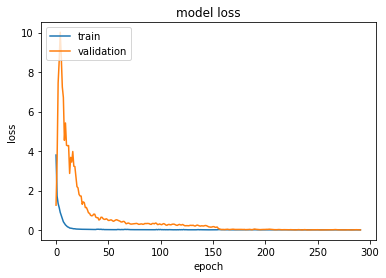

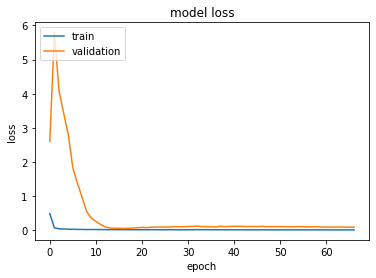

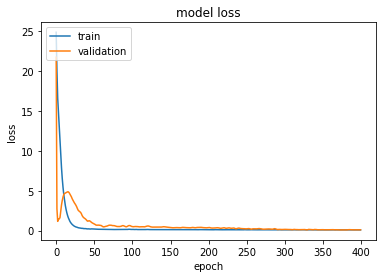

In [ ]:
plot_loss(history_benzene)
plot_loss(history_carbon)
plot_loss(history_nitrogen)

Predicting the result

In [ ]:
ypred_benzene = model_benzene.predict(X_val)
ypred_carbon = model_carbon.predict(X_val)
ypred_nitrogen = model_nitrogen.predict(X_val)

In [ ]:
pred_benzene = list(np.concatenate(ypred_benzene.tolist()).flat)
y_val_benzene = list(yval_benzene)

pred_carbon = list(np.concatenate(ypred_carbon.tolist()).flat)
y_val_carbon = list(yval_carbon)

pred_nitrogen = list(np.concatenate(ypred_nitrogen.tolist()).flat)
y_val_nitrogen = list(yval_nitrogen)


Validation MAPE


In [ ]:
mape_b = mape(y_val_benzene, pred_benzene).numpy()
mape_c = mape(y_val_carbon, pred_carbon).numpy()
mape_n = mape(y_val_nitrogen, pred_nitrogen).numpy()
(mape_b+mape_c+mape_n)/3

28.42654037475586

Validation MAE

In [ ]:
mae_b = mae(y_val_benzene, pred_benzene).numpy()
mae_c = mae(y_val_carbon, pred_carbon).numpy()
mae_n = mae(y_val_nitrogen, pred_nitrogen).numpy()
(mae_b+mae_c+mae_n)/3

15.8564865787824

Validation RMSLE

In [ ]:
rmsleb = np.sqrt(msle(y_val_benzene,pred_benzene))
rmslec = np.sqrt(msle(y_val_carbon, pred_carbon))
rmslen = np.sqrt(msle(y_val_nitrogen, pred_nitrogen)) 
(rmsleb + rmslec + rmslen)/3

0.2178649877994726

Validation RMSE

In [ ]:
mse_b = np.sqrt(mse(y_val_benzene, pred_benzene).numpy())
mse_c = np.sqrt(mse(y_val_carbon, pred_carbon).numpy())
mse_n = np.sqrt(mse(y_val_nitrogen, pred_nitrogen).numpy())
(mse_b+mse_c+mse_n)/3

27.143539030946794

Validation $R^2$

In [ ]:
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_val_nitrogen, pred_nitrogen)
r2_b = metric.result()
metric.update_state(y_val_nitrogen, pred_nitrogen)
r2_c = metric.result()
metric.update_state(y_val_nitrogen, pred_nitrogen)
r2_n = metric.result()
((r2_b + r2_c + r2_n)/3).numpy()

0.8289793

Training model again on Testing and Valiation data combined

In [ ]:
model_benzene = make_model_benzene()
history_benzene = model_benzene.fit(X, y_b, epochs=400, verbose=True, 
                                    validation_data = (X_test, ytst_benzene), batch_size = 2048)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 1024)              14336     
                                                                 
 leaky_re_lu_99 (LeakyReLU)  (None, 1024)              0         
                                                                 
 batch_normalization_99 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_99 (Dropout)        (None, 1024)              0         
                                                                 
 dense_130 (Dense)           (None, 1024)              1049600   
                                                                 
 leaky_re_lu_100 (LeakyReLU)  (None, 1024)             0         
                                                     

Save the model

In [ ]:
filename = DATA_DIR + 'Models/Benzene'
model_benzene.save(filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SMLModels/Benzene/assets


Load the model

In [ ]:
filename = DATA_DIR + 'Models/Benzene'
model_benzene = tf.keras.models.load_model(filename)
print(model)

In [ ]:
model_carbon = make_model_carbon()
history_carbon = model_carbon.fit(X, y_c, epochs=400, verbose=True,
                                  validation_data = (X_test, ytst_carbon), batch_size = 1024)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 2048)              28672     
                                                                 
 leaky_re_lu_62 (LeakyReLU)  (None, 2048)              0         
                                                                 
 batch_normalization_62 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_62 (Dropout)        (None, 2048)              0         
                                                                 
 dense_82 (Dense)            (None, 1024)              2098176   
                                                                 
 leaky_re_lu_63 (LeakyReLU)  (None, 1024)              0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6/6 [==============================] - 3s 109ms/step - loss: 0.4774 - mae: 3.2973 - mse: 23.9958 - mape: 381.2780 - val_loss: 3.6386 - val_mae: 21.1804 - val_mse: 644.0142 - val_mape: 1586.0581
Epoch 2/400
6/6 [==============================] - 0s 39ms/step - loss: 0.1240 - mae: 2.4607 - mse: 24.9680 - mape: 406.8245 - val_loss: 6.9063 - val_mae: 38.9388 - val_mse: 1702.6453 - val_mape: 2391.6223
Epoch 3/400
6/6 [==============================] - 0s 39ms/step - loss: 0.0740 - mae: 1.4197 - mse: 10.3960 - mape: 251.9948 - val_loss: 6.2308 - val_mae: 32.8662 - val_mse: 1170.6660 - val_mape: 2123.2046
Epoch 4/400
6/6 [==============================] - 0s 37ms/step - loss: 0.0522 - mae: 0.8585 - mse: 3.8792 - mape: 139.1083 - val_loss: 4.2593 - val_mae: 19.9130 - val_mse: 423.6998 - val_mape: 1336.9893
Epoch 5/400
6/6 [==============================] - 0s 36ms/step - loss: 0.0395 - mae: 0.4813 - mse: 0.6574 - mape: 43.3076 - val_loss: 4.3085 - val_mae: 20.3373 - val_mse: 444.0687 - val_map

Save the model

In [ ]:
filename = DATA_DIR + 'Models/Carbon'
model_carbon.save(filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SMLModels/Carbon/assets


Load the model

In [ ]:
filename = DATA_DIR + 'Models/Carbon'
model_carbon = tf.keras.models.load_model(filename)
print(model)

In [ ]:
model_nitrogen = make_model_nitrogen()
history_nitrogen = model_nitrogen.fit(X, y_n, epochs=400, verbose=True, 
                                      validation_data = (X_test, ytst_nitrogen), batch_size = 4096)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 2048)              28672     
                                                                 
 leaky_re_lu_76 (LeakyReLU)  (None, 2048)              0         
                                                                 
 batch_normalization_76 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_76 (Dropout)        (None, 2048)              0         
                                                                 
 dense_100 (Dense)           (None, 2048)              4196352   
                                                                 
 leaky_re_lu_77 (LeakyReLU)  (None, 2048)              0         
                                                     

Save the model

In [ ]:
filename = DATA_DIR + 'Models/Nitrogen'
model_nitrogen.save(filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SMLModels/Nitrogen/assets


Load the model

In [ ]:
filename = DATA_DIR + 'Models/Nitrogen'
model_nitrogen = tf.keras.models.load_model(filename)
print(model)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

Training and testing loss

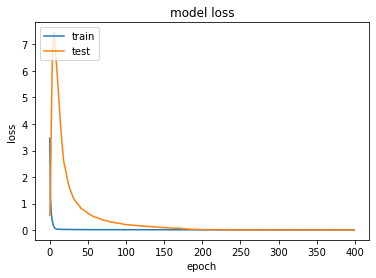

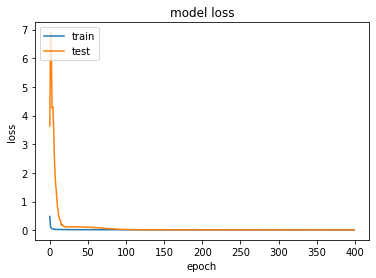

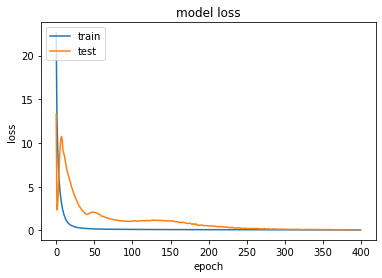

In [ ]:

plot_loss(history_benzene)
plot_loss(history_carbon)
plot_loss(history_nitrogen)

In [ ]:
ypred_benzene = model_benzene.predict(X_test)
ypred_carbon = model_carbon.predict(X_test)
ypred_nitrogen = model_nitrogen.predict(X_test)

In [ ]:
pred_benzene = list(np.concatenate(ypred_benzene.tolist()).flat)
y_test_benzene = list(ytst_benzene)

pred_carbon = list(np.concatenate(ypred_carbon.tolist()).flat)
y_test_carbon = list(ytst_carbon)

pred_nitrogen = list(np.concatenate(ypred_nitrogen.tolist()).flat)
y_test_nitrogen = list(ytst_nitrogen)


Validation MAPE


In [ ]:
mape_b = mape(y_test_benzene, pred_benzene).numpy()
mape_c = mape(y_test_carbon, pred_carbon).numpy()
mape_n = mape(y_test_nitrogen, pred_nitrogen).numpy()
(mape_b+mape_c+mape_n)/3

14.83389409383138

Validation MAE

In [ ]:
mae_b = mae(y_test_benzene, pred_benzene).numpy()
mae_c = mae(y_test_carbon, pred_carbon).numpy()
mae_n = mae(y_test_nitrogen, pred_nitrogen).numpy()
(mae_b+mae_c+mae_n)/3

14.225171114007631

Validation RMSLE

In [ ]:
rmsleb = np.sqrt(msle(y_test_benzene,pred_benzene))
rmslec = np.sqrt(msle(y_test_carbon, pred_carbon))
rmslen = np.sqrt(msle(y_test_nitrogen, pred_nitrogen)) 
(rmsleb + rmslec + rmslen)/3

0.15604926678234116

Validation RMSE

In [ ]:
mse_b = np.sqrt(mse(y_test_benzene, pred_benzene).numpy())
mse_c = np.sqrt(mse(y_test_carbon, pred_carbon).numpy())
mse_n = np.sqrt(mse(y_test_nitrogen, pred_nitrogen).numpy())
(mse_b+mse_c+mse_n)/3

26.880676753912635

Validation $R^2$

In [ ]:
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_test_nitrogen, pred_nitrogen)
r2_b = metric.result()
metric.update_state(y_test_nitrogen, pred_nitrogen)
r2_c = metric.result()
metric.update_state(y_test_nitrogen, pred_nitrogen)
r2_n = metric.result()
((r2_b + r2_c + r2_n)/3).numpy()

0.8406193